In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns

from aesara import tensor as at
from matplotlib import pyplot as plt

from scipy import stats as st

import aesara

%config InlineBackend.figure_format = "retina"
%matplotlib inline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


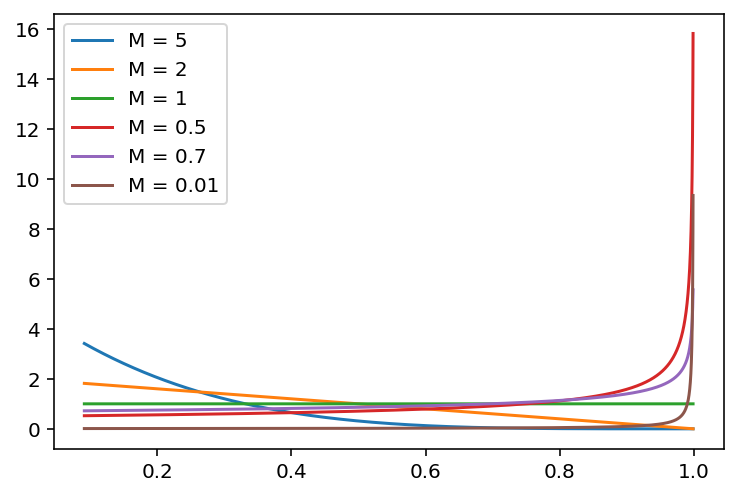

In [2]:
x_plot = np.linspace(0.091, 0.999, 9981)

for M in [5, 2, 1, 0.5, 0.7, 0.01]:
    plt.plot(x_plot, np.exp(pm.Beta.logp(x_plot, 1, M).eval()), label=f"M = {M}")
    
plt.legend()

In [3]:
K = 19; M = 0.5
rng = np.random.RandomState(seed=123)
n_samples = [5, 10, 25, 50, 100, 500, 1000]

In [4]:
def generate_sticks(M, rng, size):
    
    N = size[0]
    betas = rng.beta(1., M, size=size)
    
    sticks = np.hstack(
        [
            np.ones(shape=[N, 1]),
            np.cumprod(1 - betas[:, :-1], axis=1),
        ]
    )

    product = betas * sticks
    
    last_column = 1 - product.sum(axis=1)[..., np.newaxis] 
    # adding last column to sampler seems to cause problems?
    # to be added later once I know exactly why I'm getting errors for M < 1
    
    return product

def stick_glueing(sticks):
    
    N = sticks.shape[0]
    
    # sticks = [w1, w2, ..., wK]
    # denominator = [1, -w1, -w2, ..., wK]
    denominator = np.hstack(
        [
            np.ones(shape=[N, 1]),
            - sticks,
        ]
    )
    
    denominator = np.cumsum(denominator, axis=1)
    
    # after cumsum, denominator = [1, 1 - w1, 1 - w1 - w2, ..., 1 - w1 - w2 - ... - wK]
    
    # output is now [w1/1, w2/(1 - w1), w3/(1 - w1 - w2), ..., wK/(1 - w1 - ... - wK-1)]
    
    return sticks/(denominator[:, :-1])

In [5]:
test = np.broadcast_to(np.linspace(0, 4, num=5), [3, 5])
test

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.]])

In [6]:
np.cumsum(test, axis=1)

array([[ 0.,  1.,  3.,  6., 10.],
       [ 0.,  1.,  3.,  6., 10.],
       [ 0.,  1.,  3.,  6., 10.]])

In [12]:
def largest_K(M, lower_bound_on_wK=1e-2):
    # upper bound for K in the case of small M
    # rounding down
    return ((np.log(lower_bound_on_wK) + np.log(M+1))/np.log(M/(M+1)) + 1).astype(int)

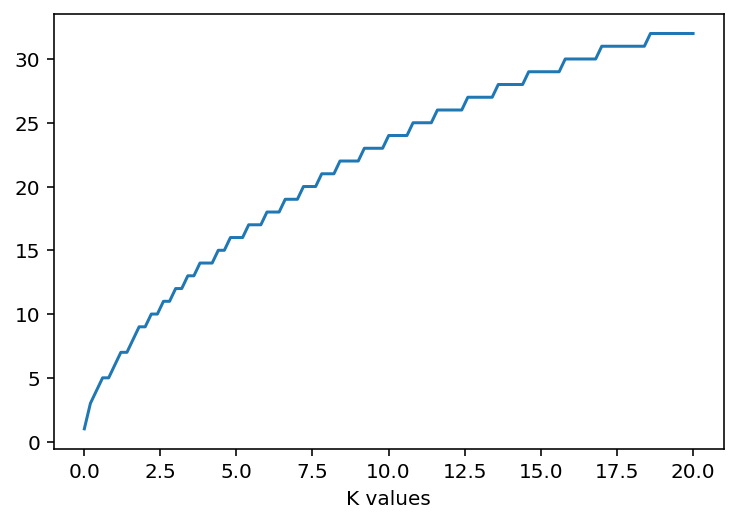

In [8]:
K_plot = np.linspace(0.01, 20, num=101)

_ = plt.plot(K_plot, largest_K(K_plot))
_ = plt.xlabel("K values")

In [9]:
class Simulation:
    
    def __init__(self, M, n_samples, K=None, verbose=True):
        """
        Default K is 19 for M >= 1
        """
        self.M = M
        self.n_samples = n_samples
        
        if K is None:
            if self.M < 1:
                self.K = int(largest_K(M))
            else:
                self.K = 19
        else:
            self.K = K
        
        if verbose:
            print(f"We're using a K value of {self.K}")
            
        if self.K < 3:
            raise ValueError("You're value of M is too small! Please increasing it to at least 0.1")
        
    def run(self):
        posterior_samples = {}

        for n in n_samples:
            sticks = generate_sticks(M=self.M, rng=rng, size=[n, self.K])
            
            recovered_betas = stick_glueing(sticks)
            
            failing_conditions = [
                (recovered_betas >= 1).any(),
                (recovered_betas <= 0).any(),
                (sticks == 0).any()
            ]
            
            if any(failing_conditions):
                raise ValueError("Beta realizations need to be between 0 and 1.")
            
            with pm.Model() as model:
                α = pm.Uniform("α", 0., 10.)
                β = pm.Beta("β", 1., α, shape=(self.K,), observed=recovered_betas)

                prior = pm.sample_prior_predictive(samples=1000)
                trace = pm.sample(draws=3000, chains=1)

            posterior_samples[n] = trace.to_dict()["posterior"]["α"][0]
            
        self.df = pd.DataFrame(posterior_samples)
        
    def plot(self):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        sns.boxplot(data=self.df, palette="Set2")
        plt.axhline(y=self.M, linestyle="-.", c="k")
        plt.show()

Simulation works out well for M = 1, 2 and 5. I removed the codes for them to focus our attention on cases where things can become unstable.

We're using a K value of 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


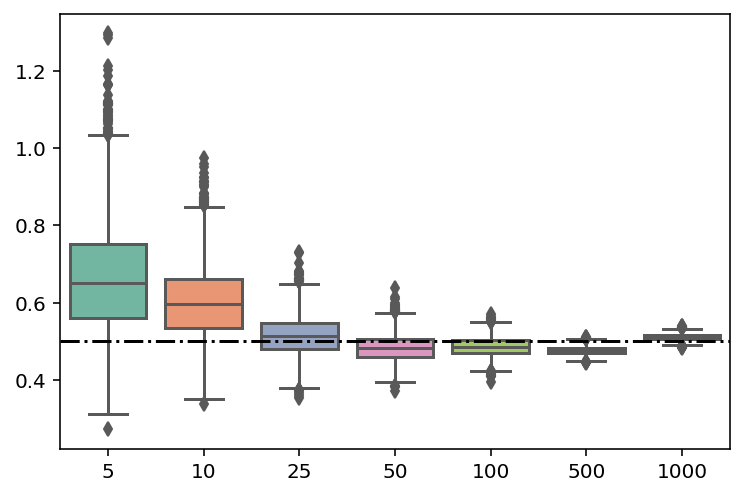

In [10]:
sim = Simulation(M=0.5, n_samples=n_samples)
sim.run()
sim.plot()

In [11]:
sim = Simulation(M=0.2, n_samples=n_samples)
sim.run()
sim.plot()

We're using a K value of 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8810900729283133, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
<ipython-input-4-2f83ec9b42f0>:38: RuntimeWarning: invalid value encountered in true_divide
  return sticks/(denominator[:, :-1])


ValueError: Beta realizations need to be between 0 and 1.

In [ ]:
sim = Simulation(M=0.01, n_samples=n_samples)
sim.run()
sim.plot()